In [2]:

import os
from pathlib import Path
import sys
from pathlib import Path

# Ajouter le dossier courant (ou celui contenant funcs.py) au PYTHONPATH
sys.path.append(str(Path().resolve()))

import mne
from pydub import AudioSegment
from collections import Counter
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.stats import zscore

import scipy.io
import os
import numpy as np
import sys
print(sys.executable)
import spyeeg
print(spyeeg.__file__)

from funcs import vhdr_to_mne, bipolar_montage, prepare_data, load_sorciere_regressors, load_laure_sorciere_regressors

c:\Users\nadege\anaconda3\envs\mon_env_mne_2\python.exe
c:\Users\nadege\anaconda3\envs\mon_env_mne_2\lib\site-packages\spyeeg\__init__.py


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pydub import AudioSegment
import mne

def align(raw_fif, raw_array, stim_dir, offset):
    # --- Load and extract trigger from audio ---
    aud = AudioSegment.from_file(stim_dir, format="mp3")
    fs_stim = aud.frame_rate
    trigger_channel = np.array(aud.split_to_mono()[1].get_array_of_samples())

    # --- Detect trigger onset in audio using threshold ---
    threshold = 3000
    stim_onsets = [idx for idx in range(2, len(trigger_channel))
                   if trigger_channel[idx] > threshold and
                      trigger_channel[idx-1] < threshold and
                      trigger_channel[idx-2] < threshold]
    trigg_stim = np.array(stim_onsets) / fs_stim

    # --- Load SEEG trigger events ---
    fs_data = raw_fif.info['sfreq']
    orig_events, _ = mne.events_from_annotations(raw_fif)
    offset_samples = int((offset / 1000) * fs_data)

    # --- Get most frequent event type (main trigger) ---
    event_code = Counter(orig_events[:, 2]).most_common(1)[0][0]
    trigg_data_samples = orig_events[orig_events[:, 2] == event_code, 0].squeeze()
    trigg_data_samples = trigg_data_samples + offset_samples
    trigg_data_secondes = trigg_data_samples / fs_data

    # --- Plot: before alignment ---
    plt.figure()
    plt.vlines(trigg_data_secondes, 0, 1, label="trigg_data")
    plt.vlines(trigg_stim, 1, 2, color='orange', label="trigg_stim")
    plt.xlim(0, 10)
    plt.legend()
    plt.xlabel('Time (sec)')
    plt.title("Before alignment")

    print(f"data : {len(trigg_data_secondes)}")
    print(f"stim : {len(trigg_stim)}")

    # --- Align triggers with iterative delay correction ---
    threshold_sec = 0.005
    i = 0
    while i < min(len(trigg_data_secondes), len(trigg_stim)) - 5:
        if len(trigg_data_secondes) == len(trigg_stim):
            trigg_stim_zero = trigg_stim - trigg_stim[0]
            trigg_data_zero = trigg_data_secondes - trigg_data_secondes[0]
        elif len(trigg_data_secondes) < len(trigg_stim):
            trigg_stim_zero = trigg_stim - trigg_stim[i]
            trigg_data_zero = trigg_data_secondes - trigg_data_secondes[0]
        else:
            trigg_stim_zero = trigg_stim - trigg_stim[0]
            trigg_data_zero = trigg_data_secondes - trigg_data_secondes[i]

        delay_matrix = np.subtract.outer(trigg_data_zero, trigg_stim_zero)

        if len(trigg_data_zero) <= len(trigg_stim_zero):
            trigg_stim_synced = [trigg_stim_zero[np.argmin(np.abs(delay_matrix[j, :]))]
                                 for j in range(len(trigg_data_zero))]
            paired_diff = trigg_data_zero - np.array(trigg_stim_synced)
        else:
            trigg_data_synced = [trigg_data_zero[np.argmin(np.abs(delay_matrix[:, j]))]
                                 for j in range(len(trigg_stim_zero))]
            paired_diff = np.array(trigg_data_synced) - trigg_stim_zero

        delay_ms = np.abs(round(np.mean(paired_diff), 4)) * 1000
        print(f"Trigger index shift: {i}")
        print(f"Mean delay: {delay_ms:.2f} ms")

        if np.abs(round(np.mean(paired_diff), 4)) > threshold_sec:
            i += 1
            continue
        else:
            # --- Extract aligned data ---
            if i == 0:
                raw_array_ = raw_array[trigg_data_samples[0]:trigg_data_samples[-1], :]
            elif len(trigg_data_secondes) < len(trigg_stim):
                raw_array_ = raw_array[trigg_data_samples[0]:trigg_data_samples[-1], :]
                padding = int((trigg_stim[i] - trigg_stim[0]) * fs_data)
                raw_array_ = np.concatenate((np.zeros((padding, raw_array_.shape[1])), raw_array_), axis=0)
            else:
                raw_array_ = raw_array[trigg_data_samples[i]:trigg_data_samples[-1], :]
            break

    # --- Plot: after alignment ---
    plt.figure()
    plt.vlines(trigg_data_zero, 0, 1, label="trigg_data")
    plt.vlines(trigg_stim_zero, 1, 2, color='orange', label="trigg_stim")
    plt.legend()
    plt.title("After alignment")
    plt.xlim(-1, 10)
    plt.show()

    # --- Delay report: trigger-by-trigger ---
    plt.figure(figsize=(15, 4))
    plt.plot(paired_diff * 1000)
    plt.axhline(y=0, color='black', linestyle=':', linewidth=2)
    plt.title("Trigger delay over time")
    plt.xlabel("Trigger index")
    plt.ylabel("Delay (ms)")
    plt.grid(True)
    plt.show()

    # # --- Delay matrix heatmap ---
    # plt.figure(figsize=(10, 8))
    # plt.imshow(np.abs(delay_matrix) * 1000, aspect='auto', cmap='Purples', origin='lower', vmin=0, vmax=50)
    # plt.colorbar(label='Temporal gap (ms)')
    # plt.title("Trigger delay matrix")
    # plt.xlabel("Audio Triggers")
    # plt.ylabel("SEEG Triggers")
    # plt.show()

    # --- Detect suspicious SEEG gaps only ---
    def detect_seeg_gaps(trigger_times, multiplier=2):
        diffs = np.diff(trigger_times)
        median_gap = np.median(diffs)
        threshold = median_gap * multiplier
        suspect_idx = np.where(diffs > threshold)[0]
        print(f"🔍 SEEG - Suspicious gaps: {len(suspect_idx)} (threshold = {threshold:.3f}s)")
        if len(suspect_idx) > 0:
            print(f"⚠️  SEEG - Suspicious gaps at indices: {suspect_idx}")
        return suspect_idx, diffs, threshold

    suspect_idx, seeg_diffs, th_seeg = detect_seeg_gaps(trigg_data_secondes)

    # --- Final alignment quality report ---
    paired_count = min(len(trigg_data_zero), len(trigg_stim_zero))
    std_ms = np.std(paired_diff) * 1000
    print(f"✔️  Aligned {paired_count} trigger pairs.")
    print(f"📉  Lost triggers: {len(trigg_stim) - paired_count}")
    print(f"📏  Std deviation of alignment (ms): {std_ms:.2f}")
    
    # Optional rating of alignment
    if std_ms < 5:
        print("✅ Excellent alignment")
    elif std_ms < 20:
        print("🟡 Acceptable alignment with some jitter")
    else:
        print("🔴 Poor alignment – investigate further")


    # --- Plot suspicious SEEG gaps only ---
    plt.figure(figsize=(12, 4))
    plt.bar(suspect_idx, seeg_diffs[suspect_idx], color='red', alpha=0.7, label='SEEG suspicious gaps')
    plt.axhline(y=th_seeg, linestyle='--', color='black', label='SEEG threshold')
    plt.title("Suspicious Trigger Gaps (SEEG only)")
    plt.xlabel("Trigger index")
    plt.ylabel("Gap (s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    return raw_array_


In [4]:
def align_origin(raw_fif, raw_array, stim_dir):
    stim_name = os.path.basename(stim_dir)
    aud = AudioSegment.from_file(stim_dir, format="mp3")
    fs_stim = aud.frame_rate

    chans = aud.split_to_mono()
    trigg = chans[1].get_array_of_samples()

    seuil = 3000
    thrsh_exceed_idx = [
        idx for idx in range(2, len(trigg))
        if trigg[idx] > seuil and trigg[idx - 1] < seuil and trigg[idx - 2] < seuil
    ]
    trigg_stim = np.array(thrsh_exceed_idx) / fs_stim

    fs_data = raw_fif.info['sfreq']
    orig_events, events_dict = mne.events_from_annotations(raw_fif)
    t_int = Counter(orig_events[:, 2]).most_common(1)[0][0]
    trigg_data_samples = np.squeeze(orig_events[orig_events[:, 2] == t_int, 0])
    trigg_data_secondes = trigg_data_samples / fs_data

    print('stim :', len(trigg_stim))

    i = 0
    max_iteration = 500

    while True:
        if i >= max_iteration:
            raise RuntimeError(f"Alignement échoué après {max_iteration} tentatives (patient bloquant ?)")

        if len(trigg_data_secondes) == len(trigg_stim):
            trigg_stim_zero = trigg_stim - trigg_stim[0]
            trigg_data_zero = trigg_data_secondes - trigg_data_secondes[0]

        elif len(trigg_data_secondes) < len(trigg_stim):
            print('< number of trigger')
            if i >= len(trigg_stim):
                break
            trigg_stim_zero = trigg_stim - trigg_stim[i]
            trigg_data_zero = trigg_data_secondes - trigg_data_secondes[0]

        else:
            print('> number of trigger')
            if i >= len(trigg_data_secondes):
                break
            trigg_stim_zero = trigg_stim - trigg_stim[0]
            trigg_data_zero = trigg_data_secondes - trigg_data_secondes[i]

        matrice_differences = trigg_data_zero[:, None] - trigg_stim_zero[None, :]

        if len(trigg_data_zero) <= len(trigg_stim_zero):
            trigg_stim_zero_syncr = [
                trigg_stim_zero[np.argmin(np.abs(matrice_differences[j, :]))]
                for j in range(len(trigg_data_zero))
            ]
            diff_diag = [
                trigg_data_zero[j] - trigg_stim_zero_syncr[j]
                for j in range(len(trigg_data_zero))
            ]

        else:
            trigg_data_zero_syncr = [
                trigg_data_zero[np.argmin(np.abs(matrice_differences[:, j]))]
                for j in range(len(trigg_stim_zero))
            ]
            diff_diag = [
                trigg_data_zero_syncr[j] - trigg_stim_zero[j]
                for j in range(len(trigg_stim_zero))
            ]

        tmp = np.mean(diff_diag)
        print(f"[align i={i}] delay: {np.abs(round(tmp, 4))} s")

        if np.abs(round(tmp, 4)) > 0.005:
            i += 1
            continue
        else:
            if i == 0:
                raw_array_ = raw_array[trigg_data_samples[0]:trigg_data_samples[-1], :]
            else:
                if len(trigg_data_secondes) < len(trigg_stim):
                    raw_array_ = raw_array[trigg_data_samples[0]:trigg_data_samples[-1], :]
                    zrs = int((trigg_stim[i] - trigg_stim[0]) * fs_data)
                    add_zeros = np.zeros((zrs, raw_array_.shape[1]))
                    raw_array_ = np.concatenate((add_zeros, raw_array_), axis=0)
                else:
                    raw_array_ = raw_array[trigg_data_samples[i]:trigg_data_samples[-1], :]
            break

    return raw_array_


In [5]:
def resample_and_shuffle_predictors(X, fs_old, fs_new, n_samples, n_permut):
    """
    Crée une matrice 3D contenant les versions réelles et permutées des régresseurs.
    
    Paramètres :
        X : array (n_time, n_regressors)
        fs_old : fréquence d'échantillonnage d'origine
        fs_new : fréquence cible (souvent identique à fs_old)
        n_samples : nombre d'échantillons cible (données EEG)
        n_permut : nombre de permutations
    
    Retour :
        X_resampled_shuffled : array (n_samples, n_regressors, n_permut+1)
    """

    onset_seconds = np.argwhere(X[:, 0]) / fs_old
    onset_sample = np.argwhere(X[:, 0])

    X_resampled_shuffled = np.zeros((n_samples, X.shape[1], n_permut + 1))

    for i in range(n_permut + 1):
        X_iter = np.zeros((n_samples, X.shape[1]))
        positions = np.round(onset_seconds * fs_new).astype(int).ravel()
        X_iter[positions, 0] = 1

        for k in range(1, X.shape[1]):
            values = zscore(X[onset_sample, k].flatten())
            if i == 0:
                X_iter[positions, k] = values
            else:
                np.random.shuffle(values)
                X_iter[positions, k] = values


        X_resampled_shuffled[:, :, i] = X_iter

    return X_resampled_shuffled

In [6]:
import pickle 
regressors_path = r"\\10.67.121.210\f\Benjamin\seeg_sorciere\regressors\regressors_CamilleB"
with open(regressors_path +'/All_Regressors_not_zscored.pkl', 'rb') as file:
    all_regressors = pickle.load(file)
# Sanity check
print(f"Type du contenu : {type(all_regressors)}")
print(f"Clés si c'est un dict : {list(all_regressors.keys()) if isinstance(all_regressors, dict) else 'N/A'}")

for i, item in enumerate(all_regressors):
    assert isinstance(item, tuple) and len(item) == 2, f"Item {i} n'est pas un tuple (name, data)"
    name, data = item

    if not isinstance(name, str):
        raise TypeError(f"Nom invalide pour le régressseur {i} : {name} (type={type(name)})")

    try:
        arr = np.asarray(data, dtype=float)
    except Exception as e:
        raise ValueError(f"Régressseur '{name}' ({i}) invalide : ne peut pas être converti en float – {e}")

    if arr.ndim != 2:
        raise ValueError(f"Régressseur '{name}' ({i}) a une forme inattendue : {arr.shape}")

print("✅ Tous les régressseurs sont valides, convertibles et homogènes.")

Type du contenu : <class 'dict'>
Clés si c'est un dict : ['regressors', 'name', 'fs']


AssertionError: Item 0 n'est pas un tuple (name, data)

In [7]:
all_regressors

{'regressors': [('reg_psyl',
   array([12.09098568, -0.08270624, -0.08270624, ..., -0.08270624,
          -0.08270624, -0.08270624])),
  ('reg_syllabe_onset',
   array([-0.08272749, -0.08272749, -0.08272749, ..., -0.08272749,
          -0.08272749, -0.08272749])),
  ('reg_word_onset',
   array([-0.07086971, -0.07086971, -0.07086971, ..., -0.07086971,
          -0.07086971, -0.07086971])),
  ('reg_uterance',
   array([ 4.19192749e+01, -2.38553745e-02, -2.38553745e-02, ...,
          -2.38553745e-02, -2.38553745e-02, -2.38553745e-02])),
  ('reg_phono',
   array([ 3.19611355e+01, -3.12879997e-02, -3.12879997e-02, ...,
          -3.12879997e-02, -3.12879997e-02, -3.12879997e-02])),
  ('reg_envelope_tf',
   array([-0.98021759, -0.97972217, -0.97922439, ..., -0.95946485,
          -0.95823948, -0.95783686])),
  ('reg_peakEnv_tf',
   array([-0.07813324, -0.07843008, -0.07843008, ..., -0.07843008,
          -0.07843008, -0.07843008])),
  ('reg_envelope_tf_der',
   array([ 0.01439507,  0.007252

In [ ]:

# Définir le dossier contenant tous les dossiers patients
base_dir = Path(r"C:\Users\nadege\Desktop\camille\seeg\agnes\1000perm")

sorciere_path = Path(r"C:/Users/nadege/Desktop/camille/seeg/agnes")

# Récupérer tous les sous-dossiers
patient_dirs = [p for p in base_dir.iterdir() if p.is_dir()]

for patient_dir in patient_dirs:
    print(f"\n=== Traitement de {patient_dir.name} ===")
    
    try:
        # --- début du traitement patient ---
        
        out_path = patient_dir / "resultats"
        out_path.mkdir(parents=True, exist_ok=True)
        
        fs = 100
        vhdr_files = list(patient_dir.glob("*.vhdr"))
        sorciere_mne = vhdr_to_mne(vhdr_files)
        stim_path = sorciere_path / "stim"

        stim_files = [f for f in stim_path.glob("*.mp3") if f.is_file()]
        if not stim_files:
            raise FileNotFoundError("Aucun fichier .mp3 trouvé dans 'stim'")
        stim_audio = stim_files[0]
        
        sorciere_bipol, channels_bipol = bipolar_montage(sorciere_mne[0], chans=True)
        sorciere_bipol = [sorciere_bipol]
        
        def custom_sort(value):
            alpha_part = ''.join(filter(lambda x: x.isalpha() or x == "'", value))
            num_part = int(''.join(filter(str.isdigit, value)))
            return alpha_part, num_part
        
        sorted_channels_bipol = sorted(channels_bipol, key=custom_sort)
        sorciere_bipol_sorted = [np.empty_like(sorciere_bipol[0])]
        for i, channel_name in enumerate(sorted_channels_bipol):
            channel_index = channels_bipol.index(channel_name)
            sorciere_bipol_sorted[0][:, i] = sorciere_bipol[0][:, channel_index]
        
        scipy.io.savemat(out_path / "channels.mat", {'ch': np.array(sorted_channels_bipol)})

        sorciere_aligned = align_origin(
            raw_fif=sorciere_mne[0],
            raw_array=sorciere_bipol_sorted[0],
            stim_dir=str(stim_audio)
        )

        high_pass = 0.1
        low_pass = 35
        fs_data = sorciere_mne[0].info['sfreq']
        sorciere_ultimate = prepare_data(data=sorciere_aligned, picks=sorted_channels_bipol,
                                         high_pass=high_pass, low_pass=low_pass, fs_data=fs_data)

        sorciere_ultimate, sorciere_regs_all, sorciere_regs_all_label = load_sorciere_regressors(sorciere_path, sorciere_ultimate)

        label_to_index = {label: idx for idx, label in enumerate(sorciere_regs_all_label)}
        acoustic_names = [
            'loudness', 'brightness', 'periodicity',
            'half_rectified_der_loudness', 'half_rectified_der_brightness', 'half_rectified_der_periodicity',
            'syllabe_onset', 'onsets'
        ]
        predictive_names = ['entropy', 'surprise']

        idx_acoustic = [label_to_index[n] for n in acoustic_names]
        idx_predictive = [label_to_index[n] for n in predictive_names]

        X_sorc_full = np.squeeze(sorciere_regs_all)
        X_sorc_acoustic = X_sorc_full[:, idx_acoustic]
        X_sorc_predictive = X_sorc_full[:, idx_predictive]

        N_PERMUT = 1000
        Xp_sorc_predictive = resample_and_shuffle_predictors(
            X=X_sorc_predictive,
            fs_old=fs,
            fs_new=fs,
            n_samples=sorciere_ultimate.shape[0],
            n_permut=N_PERMUT
        )

        print(">> TRF acoustique...")
        tw_trf = [-0.3, 0.7]
        coefs_times = np.linspace(tw_trf[0], tw_trf[1], int((tw_trf[1] - tw_trf[0]) * fs + 1))
        alphas = [0, 1e-4, 1e-2, 1, 1e2, 1e4]
        X = X_sorc_acoustic
        Y = np.squeeze(sorciere_ultimate)

        trf = spyeeg.models.TRF.TRFEstimator(tmin=tw_trf[0], tmax=tw_trf[1], srate=fs, alpha=alphas, fit_domain='frequency')
        trf.xval_eval(X, Y, n_splits=5, fit_mode='direct', verbose=False)
        best_alpha = trf.get_best_alpha()
        r2 = trf.scores[np.arange(trf.scores.shape[0])[:, None], np.arange(trf.scores.shape[1])[None, :], best_alpha]
        r2_acoustic = np.mean(r2, axis=0)

        coef = trf.get_coef()
        trf_betas_acoustic = coef[
            np.arange(coef.shape[0])[:, None, None],
            np.arange(coef.shape[1])[None, :, None],
            np.arange(coef.shape[2])[None, None, :],
            best_alpha
        ]

        scipy.io.savemat(out_path / 'sorciere_acoustic.mat', {
            'r2': r2_acoustic,
            'kernels': trf_betas_acoustic,
            'channels': sorted_channels_bipol,
            'fs': fs
        })

        print(">> TRF permutations prédictives...")
        from joblib import Parallel, delayed

        X_sorc_all = [np.concatenate((X_sorc_acoustic, Xp_sorc_predictive[:, :, i]), axis=1)
                      for i in range(Xp_sorc_predictive.shape[2])]
        feats = list(range(X_sorc_all[0].shape[1]))

        def run_trf(X_sel):
            trf = spyeeg.models.TRF.TRFEstimator(tmin=tw_trf[0], tmax=tw_trf[1], srate=fs, alpha=alphas, fit_domain='frequency')
            trf.xval_eval(X_sel, Y, n_splits=5, fit_mode='direct', verbose=False)
            best_alpha = trf.get_best_alpha()
            r2 = trf.scores[np.arange(trf.scores.shape[0])[:, None], np.arange(trf.scores.shape[1])[None, :], best_alpha]
            r2_mean = np.mean(r2, axis=0)
            coef = trf.get_coef()
            coef_selected = coef[
                np.arange(coef.shape[0])[:, None, None],
                np.arange(coef.shape[1])[None, :, None],
                np.arange(coef.shape[2])[None, None, :],
                best_alpha
            ]
            return r2_mean, coef_selected

        results = Parallel(n_jobs=4, verbose=10)(
            delayed(run_trf)(X_i[:, feats]) for X_i in X_sorc_all
        )

        r2_all = np.stack([r for r, _ in results], axis=1)
        trf_betas = results[0][1]
        r2_real_sorciere = r2_all[:, 0]
        r2_perm_sorciere = r2_all[:, 1:]
        pval_sorciere = np.mean(r2_perm_sorciere >= r2_real_sorciere[:, None], axis=1)

        scipy.io.savemat(out_path / 'sorciere_predictive.mat', {
            'r2_real': r2_real_sorciere,
            'r2_perm': r2_perm_sorciere,
            'pval': pval_sorciere,
            'kernels': trf_betas,
            'channels': sorted_channels_bipol,
            'fs': fs
        })

        # print(">> MATLAB : PCI")
        # import matlab.engine
        # eng = matlab.engine.start_matlab()
        # eng.eval(f"out_path = '{out_path}'; run('C:/Users/nadege/Desktop/camille/seeg/agnes/sEEG_rsqr_pci.m')", nargout=0)
        # print(f"✅ Patient {patient_dir.name} terminé avec succès.")

        # --- fin du traitement patient ---

    except Exception as e:
        print(f"❌ Erreur pour le patient {patient_dir.name} : {type(e).__name__} – {e}")
        continue  # passe au patient suivant


# Here

In [8]:
def permutation_predictors(X, fs_old, fs_new, n_samples, n_permut, roll_idx=None):
    """
    Crée une matrice 3D contenant les versions réelles et permutées des régresseurs.
    Utilise np.roll pour les régresseurs discrets comme 'onsets', et shuffle pour les autres.
    
    Paramètres :
        X : array (n_time, n_regressors)
        fs_old : fréquence d'échantillonnage d'origine
        fs_new : fréquence cible (souvent identique à fs_old)
        n_samples : nombre d'échantillons cible (données EEG)
        n_permut : nombre de permutations
        roll_idx : liste des indices (colonnes) à permuter avec np.roll (ex: [2] pour 'onsets')

    Retour :
        X_resampled_shuffled : array (n_samples, n_regressors, n_permut+1)
    """
    if roll_idx is None:
        roll_idx = []

    onset_seconds = np.argwhere(X[:, 0]) / fs_old
    onset_sample = np.argwhere(X[:, 0])
    positions = np.round(onset_seconds * fs_new).astype(int).ravel()

    X_resampled_shuffled = np.zeros((n_samples, X.shape[1], n_permut + 1))

    for i in range(n_permut + 1):
        X_iter = np.zeros((n_samples, X.shape[1]))
        X_iter[positions, 0] = 1  # la première colonne est l’événement d’origine

        for k in range(1, X.shape[1]):
            if k in roll_idx:
                # binaire : 0 ou 1
                discrete_vector = np.zeros(n_samples)
                active_pos = np.round(np.argwhere(X[:, k]) / fs_old * fs_new).astype(int).ravel()
                discrete_vector[active_pos] = 1

                if i == 0:
                    X_iter[:, k] = discrete_vector
                else:
                    shift = np.random.randint(1, n_samples)
                    X_iter[:, k] = np.roll(discrete_vector, shift)

            else:
                values = zscore(X[onset_sample, k].flatten())
                if i == 0:
                    X_iter[positions, k] = values
                else:
                    np.random.shuffle(values)
                    X_iter[positions, k] = values

        X_resampled_shuffled[:, :, i] = X_iter

    return X_resampled_shuffled


In [9]:
import os
import pickle
import numpy as np
from scipy import stats
from scipy.signal import resample

def load_laure_regressors(data_path, data):
    """
    Fonction de remplacement 100% compatible avec load_sorciere_regressors,
    pour données .pkl contenant un dict {'regressors': [(name, values)], 'fs': int, ...}

    Retour :
        - data EEG tronqué
        - X : shape (n_time, 1, n_reg)
        - labels : liste des noms
    """

    regressors_path = os.path.join(data_path, 'stim', 'reg')

    # === Acoustiques ===
    acoustic_file = os.path.join(regressors_path, 'All_Regressors_not_zscored.pkl')
    with open(acoustic_file, 'rb') as f:
        acoustic_dict = pickle.load(f)

    assert isinstance(acoustic_dict, dict), "Format inattendu : le fichier ne contient pas un dictionnaire"
    assert 'regressors' in acoustic_dict, "'regressors' manquant dans le fichier"
    reg_list = acoustic_dict['regressors']
    fs_old = acoustic_dict.get('fs', 500)
    fs_new = 100

    # Convertir tous les régressseurs en tableaux (n_time, 1)
    reg_names = []
    reg_arrays = []
    for i, (name, values) in enumerate(reg_list):
        reg_names.append(name)
        arr = np.asarray(values).reshape(-1, 1)
        reg_arrays.append(arr)

    reg_data = np.stack(reg_arrays, axis=2)  # shape: (n_time, 1, n_reg)
    n_time_new = int(reg_data.shape[0] * fs_new / fs_old)

    # Resample et z-score
    reg_data_resampled = resample(reg_data, n_time_new, axis=0)
    reg_data_resampled = stats.zscore(reg_data_resampled, axis=0)

    # === Prédictifs ===
    pred_file = os.path.join(regressors_path, 'predictive_regressors_wd.pkl')
    with open(pred_file, 'rb') as f:
        pred_dict = pickle.load(f)

    assert 'X' in pred_dict and 'names' in pred_dict, "Clés 'X' ou 'names' absentes dans prédictifs"
    X_pred = pred_dict['X']  # shape: (n_time_pred, 1, n_reg_pred)

    # Réduire ou tronquer pour égaliser le nombre de timepoints
    if X_pred.shape[0] != reg_data_resampled.shape[0]:
        idx_to_keep = sorted(np.random.choice(
            X_pred.shape[0],
            reg_data_resampled.shape[0],
            replace=False
        ))
        X_pred = X_pred[idx_to_keep, :, :]

    # Z-score prédictifs uniquement
    X_pred = stats.zscore(X_pred, axis=0)

    # === Fusion ===
    X = np.concatenate((reg_data_resampled, X_pred), axis=2)  # shape: (n_time, 1, n_total_reg)
    X = X[:len(data), :, :]
    data = data[:len(X), :, :]

    labels = reg_names + pred_dict['names']
    return data, X, labels


In [10]:
patient_dirs

[WindowsPath('C:/Users/nadege/Desktop/camille/seeg/agnes/1000perm/Dem_Vin'),
 WindowsPath('C:/Users/nadege/Desktop/camille/seeg/agnes/1000perm/Mar_Luc'),
 WindowsPath('C:/Users/nadege/Desktop/camille/seeg/agnes/1000perm/San_Ray')]


=== Traitement de Dem_Vin ===
C:\Users\nadege\Desktop\camille\seeg\agnes\1000perm\Dem_Vin\250110C-A_0010.vhdr
250110C-A_0010.vhdr
sorciere_bipol_sorted[0].shape = (295936, 159)
Used Annotations descriptions: ['Comment/?', 'Comment/D?but', 'Stimulus/S 128', 'Stimulus/S 192', 'Stimulus/S 200']
data : 584
stim : 585
Trigger index shift: 0
Mean delay: 2.10 ms


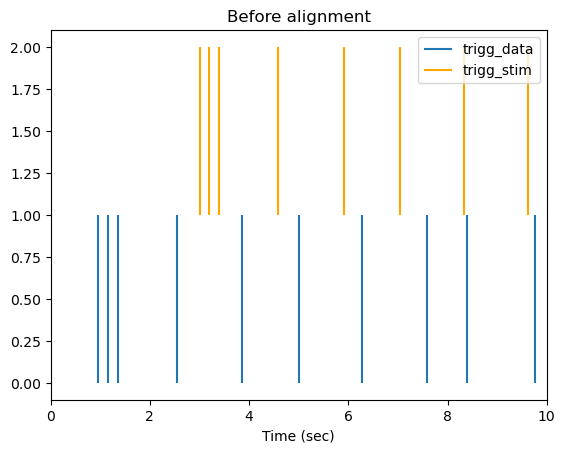

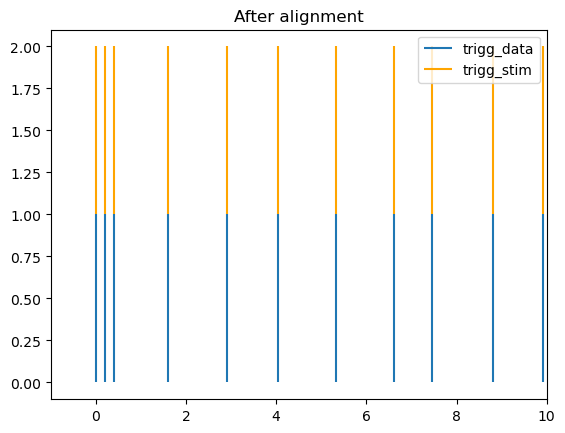

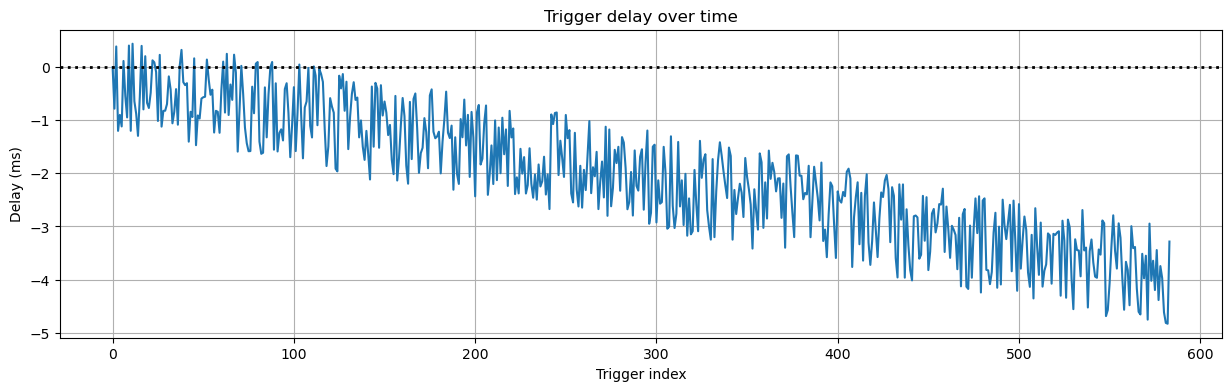

🔍 SEEG - Suspicious gaps: 0 (threshold = 1.969s)
✔️  Aligned 584 trigger pairs.
📉  Lost triggers: 1
📏  Std deviation of alignment (ms): 1.19
✅ Excellent alignment


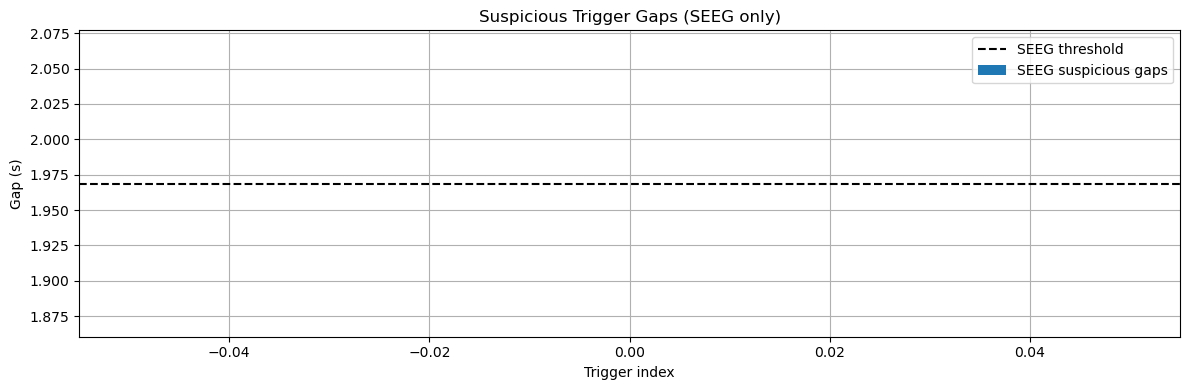

sorciere_aligned.shape = (295267, 159)


KeyboardInterrupt: 

In [12]:
from pathlib import Path
import numpy as np
import scipy.io
import os

base_dir = Path(r"C:\Users\nadege\Desktop\camille\seeg\agnes\1000perm")
sorciere_path = Path(r"C:/Users/nadege/Desktop/camille/seeg/agnes")
patient_dirs = [p for p in base_dir.iterdir() if p.is_dir()]

# 🔁 À placer en DEHORS de la boucle
excluded_patients = {"Blu_Ro", "And_Mar", "Bof_Li"}

for patient_dir in patient_dirs:
    patient_name = patient_dir.name
    print(f"\n=== Traitement de {patient_name} ===")

    if patient_name in excluded_patients:
        print(f"⏭️ Patient ignoré : {patient_name}")
        continue

    try:
        out_path = patient_dir / "laure_reg_onsets_accou_align"
        out_path.mkdir(parents=True, exist_ok=True)

        fs = 100
        vhdr_files = list(patient_dir.glob("*.vhdr"))
        sorciere_mne = vhdr_to_mne(vhdr_files)
        stim_path = sorciere_path / "stim"

        stim_files = [f for f in stim_path.glob("*.mp3") if f.is_file()]
        if not stim_files:
            raise FileNotFoundError("Aucun fichier .mp3 trouvé dans 'stim'")
        stim_audio = stim_files[0]

        sorciere_bipol, channels_bipol = bipolar_montage(sorciere_mne[0], chans=True)
        sorciere_bipol = [sorciere_bipol]

        sorted_channels_bipol = sorted(channels_bipol, key=lambda v: (''.join(filter(str.isalpha, v)), int(''.join(filter(str.isdigit, v)))))
        sorciere_bipol_sorted = [np.empty_like(sorciere_bipol[0])]
        for i, name in enumerate(sorted_channels_bipol):
            sorciere_bipol_sorted[0][:, i] = sorciere_bipol[0][:, channels_bipol.index(name)]

        print(f"sorciere_bipol_sorted[0].shape = {sorciere_bipol_sorted[0].shape}")
        scipy.io.savemat(out_path / "channels.mat", {'ch': np.array(sorted_channels_bipol)})

        try:
            sorciere_aligned = align(raw_fif=sorciere_mne[0], raw_array=sorciere_bipol_sorted[0], stim_dir=str(stim_audio), offset=0)
        except RuntimeError as e:
            print(f"⚠️ Alignement échoué pour {patient_dir.name} : {e}")
            continue

        print(f"sorciere_aligned.shape = {sorciere_aligned.shape}")
        fs_data = sorciere_mne[0].info['sfreq']
        sorciere_ultimate = prepare_data(data=sorciere_aligned, picks=sorted_channels_bipol, high_pass=0.1, low_pass=35, fs_data=fs_data)

        print(f"sorciere_ultimate.shape = {sorciere_ultimate.shape}")
        sorciere_ultimate, sorciere_regs_all, sorciere_regs_all_label = load_laure_regressors(sorciere_path, sorciere_ultimate)

        print(f"sorciere_regs_all.shape = {sorciere_regs_all.shape}")
        print(f"Nb de labels de régressseurs = {len(sorciere_regs_all_label)}")

        label_to_index = {label: idx for idx, label in enumerate(sorciere_regs_all_label)}
        acoustic_names = ['reg_envelope_tf', 'reg_envelope_tf_der', 'reg_F0Loudness', 'reg_intensity', 'reg_spectral_flux','onsets']
        predictive_names = ['entropy', 'surprise']

        idx_acoustic = [label_to_index[n] for n in acoustic_names]
        idx_predictive = [label_to_index[n] for n in predictive_names]

        X_sorc_full = np.squeeze(sorciere_regs_all)
        print(f"X_sorc_full.shape = {X_sorc_full.shape}")

        X_sorc_acoustic = X_sorc_full[:, idx_acoustic]
        X_sorc_predictive = X_sorc_full[:, idx_predictive]
        print(f"X_sorc_acoustic.shape = {X_sorc_acoustic.shape}")
        print(f"X_sorc_predictive.shape = {X_sorc_predictive.shape}")


        N_PERMUT = 1000
        Xp_sorc_predictive = resample_and_shuffle_predictors(
            X=X_sorc_predictive,
            fs_old=fs,
            fs_new=fs,
            n_samples=sorciere_ultimate.shape[0],
            n_permut=N_PERMUT
        )
        print(f"Xp_sorc_predictive.shape = {Xp_sorc_predictive.shape}")

        print(">> TRF acoustique...")
        tw_trf = [-0.3, 0.7]
        coefs_times = np.linspace(tw_trf[0], tw_trf[1], int((tw_trf[1] - tw_trf[0]) * fs + 1))
        alphas = [1e-4, 1e-2, 1, 1e2, 1e4]
        X = X_sorc_acoustic
        Y = np.squeeze(sorciere_ultimate)
        print(f"TRF input X.shape = {X.shape}, Y.shape = {Y.shape}")

        trf = spyeeg.models.TRF.TRFEstimator(tmin=tw_trf[0], tmax=tw_trf[1], srate=fs, alpha=alphas, fit_domain='frequency')
        trf.xval_eval(X, Y, n_splits=5, fit_mode='direct', verbose=False)
        best_alpha = trf.get_best_alpha()

        r2 = trf.scores[np.arange(trf.scores.shape[0])[:, None], np.arange(trf.scores.shape[1])[None, :], best_alpha]
        r2_acoustic = np.mean(r2, axis=0)
        coef = trf.get_coef()
        trf_betas_acoustic = coef[
            np.arange(coef.shape[0])[:, None, None],
            np.arange(coef.shape[1])[None, :, None],
            np.arange(coef.shape[2])[None, None, :],
            best_alpha
        ]
        print(f"trf_betas_acoustic.shape = {trf_betas_acoustic.shape}")

        scipy.io.savemat(out_path / 'sorciere_acoustic.mat', {
            'r2': r2_acoustic,
            'kernels': trf_betas_acoustic,
            'channels': sorted_channels_bipol,
            'fs': fs
        })

        print(">> TRF permutations prédictives...")
        from joblib import Parallel, delayed

        X_sorc_all = [np.concatenate((X_sorc_acoustic, Xp_sorc_predictive[:, :, i]), axis=1) for i in range(Xp_sorc_predictive.shape[2])]
        feats = list(range(X_sorc_all[0].shape[1]))

        def run_trf(X_sel):
            trf = spyeeg.models.TRF.TRFEstimator(tmin=tw_trf[0], tmax=tw_trf[1], srate=fs, alpha=alphas, fit_domain='frequency')
            trf.xval_eval(X_sel, Y, n_splits=5, fit_mode='direct', verbose=False)
            best_alpha = trf.get_best_alpha()
            r2 = trf.scores[np.arange(trf.scores.shape[0])[:, None], np.arange(trf.scores.shape[1])[None, :], best_alpha]
            r2_mean = np.mean(r2, axis=0)
            coef = trf.get_coef()
            coef_selected = coef[
                np.arange(coef.shape[0])[:, None, None],
                np.arange(coef.shape[1])[None, :, None],
                np.arange(coef.shape[2])[None, None, :],
                best_alpha
            ]
            return r2_mean, coef_selected

        results = Parallel(n_jobs=4, verbose=10)(delayed(run_trf)(X_i[:, feats]) for X_i in X_sorc_all)

        r2_all = np.stack([r for r, _ in results], axis=1)
        trf_betas = results[0][1]
        r2_real_sorciere = r2_all[:, 0]
        r2_perm_sorciere = r2_all[:, 1:]
        pval_sorciere = np.mean(r2_perm_sorciere >= r2_real_sorciere[:, None], axis=1)

        scipy.io.savemat(out_path / 'sorciere_predictive.mat', {
            'r2_real': r2_real_sorciere,
            'r2_perm': r2_perm_sorciere,
            'pval': pval_sorciere,
            'kernels': trf_betas,
            'channels': sorted_channels_bipol,
            'fs': fs
        })

    except Exception as e:
        print(f"❌ Erreur pour le patient {patient_dir.name} : {type(e).__name__} – {e}")
        continue
